The code from plot_generation.ipynb will be the foundation for most of this.

The main change I wanted to make was that the information for the Manhattan plot should be source from the GWAS sumstats file, and not the assoc.dat file.
In addition, we are interested in looking at all the chromosomes at one time for the Manahattan plot.
Since we already have that data we can make that change now.

In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from adjustText import adjust_text
import os

In [53]:
def manhattan(pop, p_threshold_significance=5e-8, subsample_cutoff=5e-1, subsample_rate=0.01):
    # Read the GWAS summary statistics file
    file_path = f'../data/raw/gwas/HF_Bothsex_{pop}_inv_var_meta_GBMI_052021_nbbkgt1.txt.gz'
    df = pd.read_csv(file_path, compression='gzip', sep='\t', header=0)

    # Ensure required columns exist
    required_cols = {'#CHR', 'POS', 'inv_var_meta_p'}
    if not required_cols.issubset(df.columns):
        raise ValueError(f"Missing required columns in input file: {required_cols - set(df.columns)}")

    # Rename columns for consistency
    df = df.rename(columns={'#CHR': 'CHR', 'inv_var_meta_p': 'P'})

    # Select relevant columns and drop missing values
    df = df[['CHR', 'POS', 'P']].dropna()
   
    # Convert P-values to -log10(P) for plotting
    df['P'] = pd.to_numeric(df['P'], errors='coerce')
    df = df.dropna()  # Drop any remaining NaNs
    df['-log10(P)'] = df['P'].apply(lambda x: -np.log10(x))

    # Convert chromosome numbers to integers for sorting
    df['CHR'] = df['CHR'].astype(int)

    # Apply filtering:
    df_significant = df[df['P'] <= subsample_cutoff]  # Keep all SNPs below threshold
    df_nonsignificant = df[df['P'] > subsample_cutoff].sample(frac=subsample_rate, random_state=42)  # Subsample 1% of non-significant SNPs

    # Combine both datasets
    df = pd.concat([df_significant, df_nonsignificant])

    # Sort by chromosome and position
    df = df.sort_values(by=['CHR', 'POS'])

    # Generate a Manhattan plot
    plt.figure(figsize=(20, 6))
    colors = ['blue', 'red']  # Alternating colors for chromosomes

    # Create chromosome index mapping
    df['Chrom_Position'] = df.groupby('CHR')['POS'].transform(lambda x: x - x.min())

    # Set up x-axis positions
    chrom_max = df.groupby('CHR')['Chrom_Position'].max()
    chrom_offsets = chrom_max.cumsum().shift(fill_value=0)
    df['Adjusted_POS'] = df['Chrom_Position'] + df['CHR'].map(chrom_offsets)

    # Define colors
    significant_color = 'red'
    gray_shades = ['darkgray', 'lightgray']

    # Plot each chromosome separately
    for i, chrom in enumerate(df['CHR'].unique()):
        chr_data = df[df['CHR'] == chrom]
    
        # Separate significant and non-significant SNPs
        chr_significant = chr_data[chr_data['P'] <= p_threshold_significance]
        chr_nonsignificant = chr_data[chr_data['P'] > p_threshold_significance]
    
        # Plot non-significant SNPs in alternating gray shades
        plt.scatter(chr_nonsignificant['Adjusted_POS'], chr_nonsignificant['-log10(P)'],
                    color=gray_shades[i % 2], s=5, alpha=0.6)
    
        # Plot significant SNPs in red
        plt.scatter(chr_significant['Adjusted_POS'], chr_significant['-log10(P)'],
                    color=significant_color, s=10)

    # Add significance threshold line
    plt.axhline(y=-np.log10(p_threshold_significance), color='black', linestyle='dashed', linewidth=1)

    # Format x-axis to show chromosome numbers
    tick_positions = chrom_offsets + chrom_max / 2
    plt.xticks(tick_positions, [str(chrom) for chrom in chrom_offsets.index])
    plt.ylim(0, 20)

    # Labels and title
    plt.xlabel("Chromosome")
    plt.ylabel("-log10(P-value)")
    plt.title(f"Manhattan Plot of GWAS Data (Population: {pop})")

    plt.savefig(f'../plots/manhattan/{pop}_manhattan_v4.png')

    plt.show()

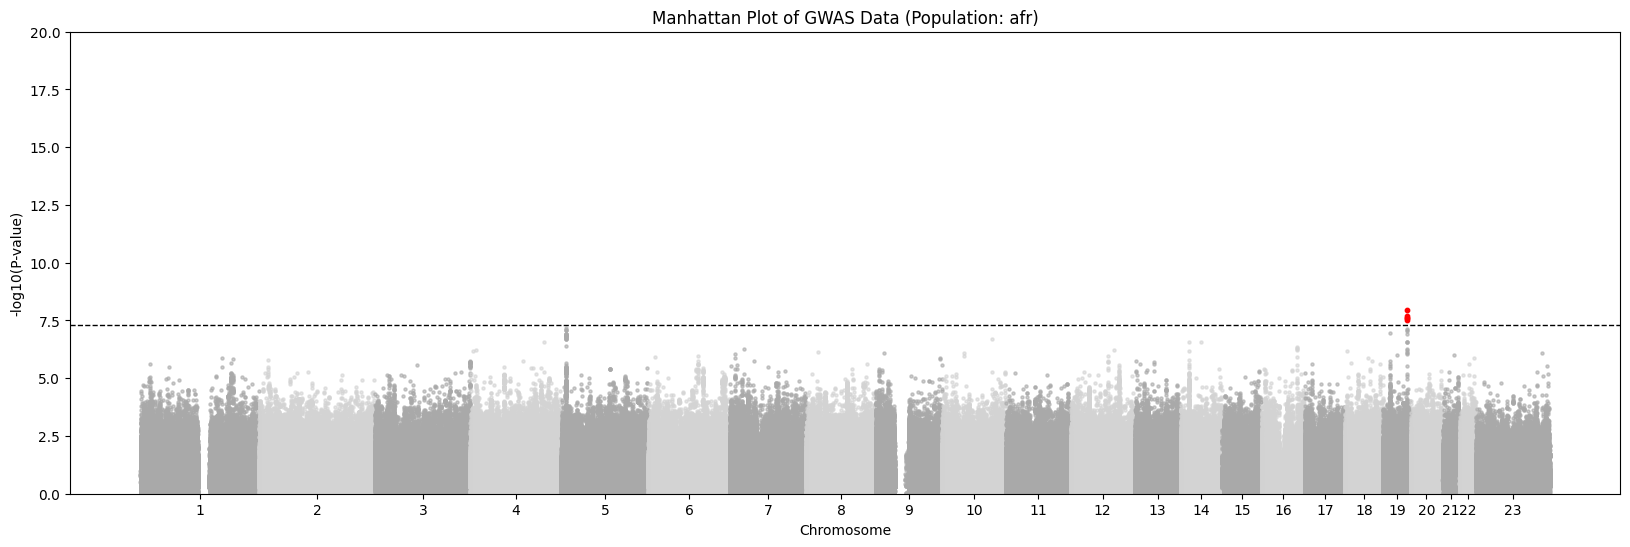

<Figure size 640x480 with 0 Axes>

In [50]:
manhattan('afr')

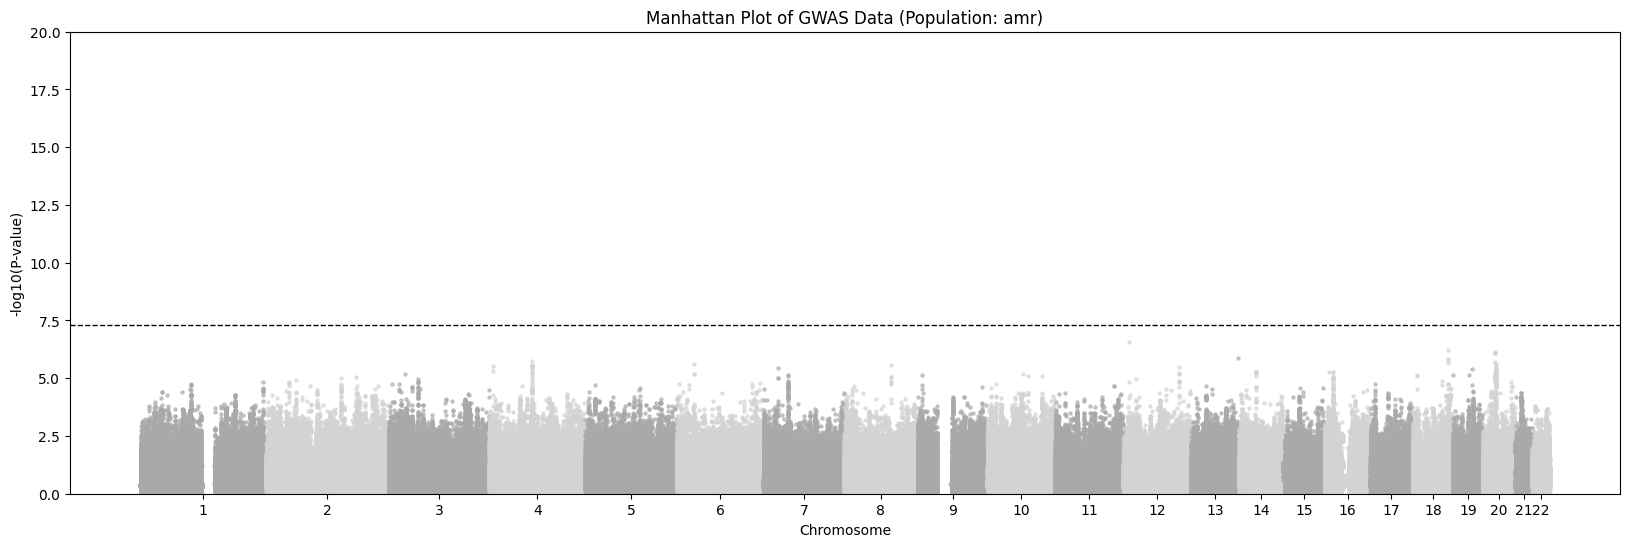

In [54]:
manhattan('amr')

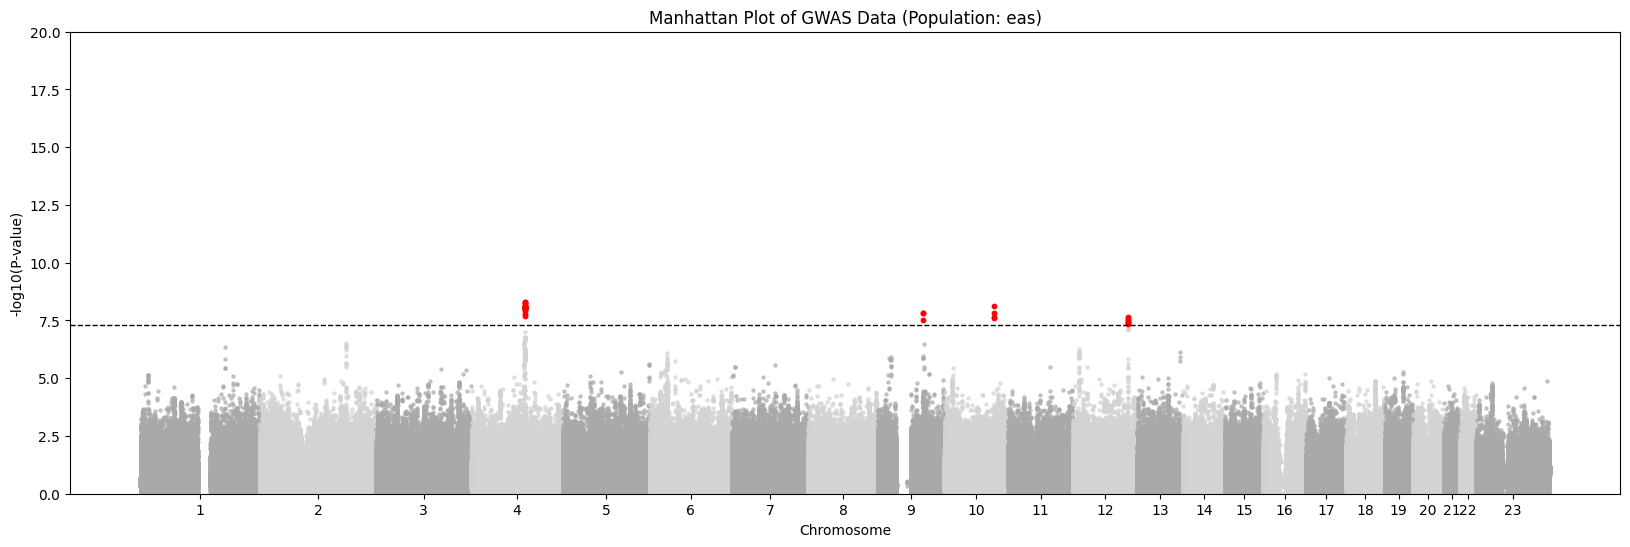

In [55]:
manhattan('eas')

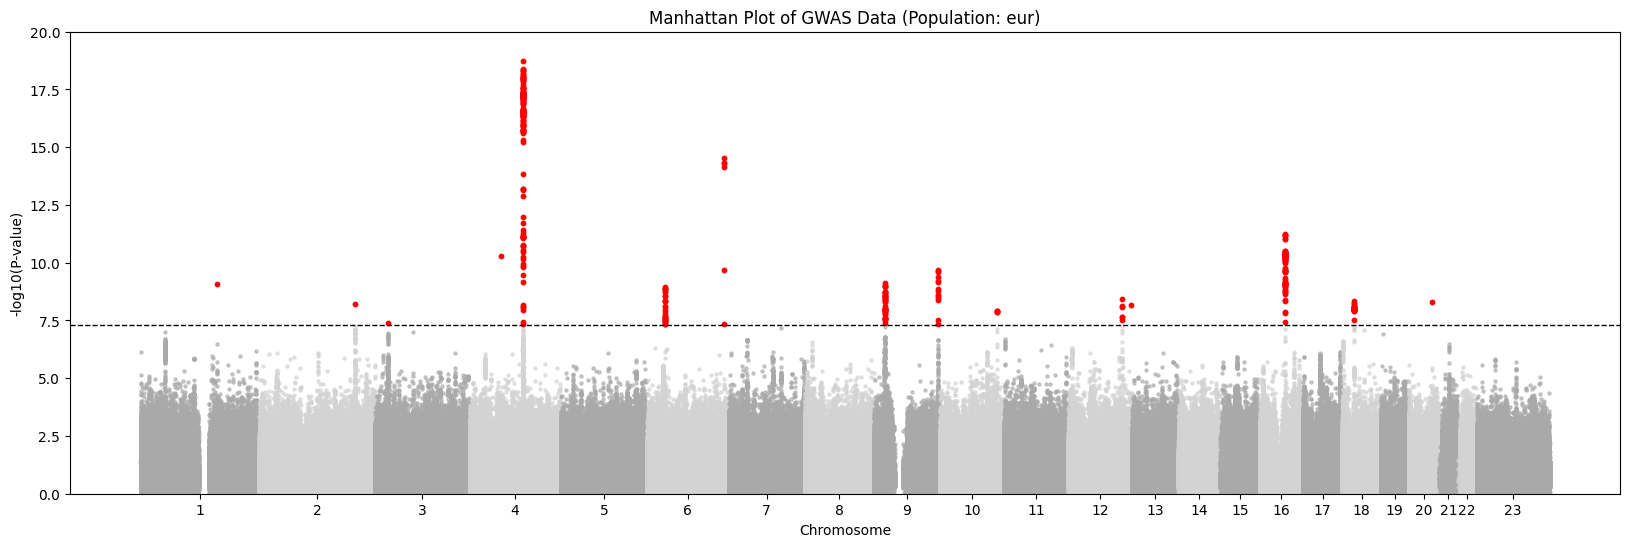

<Figure size 640x480 with 0 Axes>

In [51]:
manhattan('eur')

## Miami Plot Prep and Creation Below

In [6]:
def data_prep(pop):
    """Reads GWAS summary statistics for all chromosomes and concatenates them."""
    all_dfs = []

    for chrom_num in range(1, 23):  # Loop through chromosomes 1-22
        file_path = f'../data/gene_associations/chr{chrom_num}.{pop}.assoc.dat'
        
        try:
            df = pd.read_csv(file_path, sep="\t")

            df = df.drop(columns=['PANEL', 'FILE'])

            # Select relevant columns
            df = df[['ID', 'CHR', 'P0', 'TWAS.P']].dropna()

            # Strip whitespace and convert to numeric, forcing errors to NaN
            df['TWAS.P'] = pd.to_numeric(df['TWAS.P'].str.strip(), errors='coerce')

            # Drop NaN values
            df = df.dropna()

            # Convert P-values to -log10(P) for plotting
            df['TWAS.P'] = df['TWAS.P'].astype(float)
            df['-log10(P)'] = df['TWAS.P'].apply(lambda x: -np.log10(x))    

            # Convert chromosome numbers to integers for sorting
            df['CHR'] = df['CHR'].astype(int)

            # Sort by chromosome and position
            df = df.sort_values(by=['CHR', 'P0'])

            all_dfs.append(df)  # Store processed df

        except FileNotFoundError:
            print(f"File not found: {file_path}, skipping chromosome {chrom_num}")

    # Concatenate all chromosome data
    final_df = pd.concat(all_dfs, ignore_index=True)

    return final_df


In [36]:
data_prep('afr')

,ID,CHR,P0,TWAS.P,-log10(P)
0,SLC35E2B,1,1661477,0.70535,0.151595
1,SLC35E2,1,1724837,0.66616,0.176421
2,TNFRSF14,1,2555638,0.78687,0.104097
3,LINC00337,1,6236239,0.81942,0.086493
4,UTS2,1,7846691,0.30728,0.512466
...,...,...,...,...,...
1470,SELO,22,50200978,0.46020,0.337053
1471,MAPK12,22,50255196,0.95380,0.020543
1472,SYCE3,22,50551111,0.51000,0.292430
1473,CHKB-AS1,22,50583025,0.23060,0.637141


In [ ]:
def miami(pop):
    """Generates a Miami plot for chromosomes 1-22 comparing given population vs 'eur'."""
    
    # Get GWAS data for both populations across all chromosomes
    df1 = data_prep('eur')
    df2 = data_prep(pop)

    # Set up the plot
    plt.figure(figsize=(14, 6))
    sig_color = 'red'  # Color for significant SNPs
    grey_colors = ['lightgrey', 'darkgrey']  # Alternating grey for non-significant SNPs

    # Track chromosome positions for spacing
    chrom_offsets = {}
    cumulative_pos = 0

    for chrom in range(1, 23):
        chr_data1 = df1[df1['CHR'] == chrom]
        chr_data2 = df2[df2['CHR'] == chrom]

        if not chr_data1.empty and not chr_data2.empty:
            min_pos = min(chr_data1['P0'].min(), chr_data2['P0'].min())
            max_pos = max(chr_data1['P0'].max(), chr_data2['P0'].max())

            chr_data1 = chr_data1.copy()
            chr_data2 = chr_data2.copy()

            chr_data1.loc[:, 'plot_pos'] = chr_data1['P0'] - min_pos + cumulative_pos
            chr_data2.loc[:, 'plot_pos'] = chr_data2['P0'] - min_pos + cumulative_pos

            chrom_offsets[chrom] = cumulative_pos + (max_pos - min_pos) / 2
            cumulative_pos += max_pos - min_pos + 1e6  # Add buffer between chromosomes

            # Identify significant SNPs
            significant1 = chr_data1['-log10(P)'] >= -np.log10(5e-2)
            significant2 = chr_data2['-log10(P)'] >= -np.log10(5e-2)
            significant_annotate1 = chr_data1['-log10(P)'] >= -np.log10(1e-2)
            significant_annotate2 = chr_data2['-log10(P)'] >= -np.log10(5e-3)

            # Plot eur SNPs (bottom)
            plt.scatter(chr_data1['plot_pos'][significant1], -chr_data1['-log10(P)'][significant1],
                        color=sig_color, s=10, edgecolor='black')
            plt.scatter(chr_data1['plot_pos'][~significant1], -chr_data1['-log10(P)'][~significant1],
                        color=grey_colors[chrom % 2], s=5, alpha=0.6)
            
            # Plot pop SNPs (top)
            plt.scatter(chr_data2['plot_pos'][significant2], chr_data2['-log10(P)'][significant2],
                        color=sig_color, s=10, edgecolor='black')
            plt.scatter(chr_data2['plot_pos'][~significant2], chr_data2['-log10(P)'][~significant2],
                        color=grey_colors[chrom % 2], s=5, alpha=0.6)

            # Store all text annotations
            texts = []

            # Annotate significant SNPs with 'ID' (top)
            for i, row in chr_data2[significant_annotate2].iterrows():
                texts.append(plt.text(row['plot_pos'], row['-log10(P)'] + 0.2, row['ID'], 
                                    fontsize=7, ha='center', rotation=45))

            # Annotate significant SNPs with 'ID' (bottom)
            for i, row in chr_data1[significant_annotate1].iterrows():
                texts.append(plt.text(row['plot_pos'], -row['-log10(P)'] - 0.2, row['ID'], 
                                    fontsize=7, ha='center', rotation=45))

            # Adjust text positions to avoid overlap
            adjust_text(texts, 
            expand_text=(1.2, 1.5),  
            expand_points=(1.2, 1.5),  
            force_text=(0.3, 0.5),  
            force_points=(0.3, 0.5),  
            lim=200)  

    # Remove chromosome number blocks
    plt.xticks([])  

    # Adjust y-axis: Keep values negative but display them as positive
    max_y = max(df1['-log10(P)'].max(), df2['-log10(P)'].max()) + 1
    y_ticks = np.arange(0, np.ceil(max_y), 2)
    plt.yticks(list(-y_ticks) + list(y_ticks), labels=[str(int(abs(y))) for y in list(-y_ticks) + list(y_ticks)])
    plt.ylim(-max_y, max_y)  

    # Add genome-wide significance and 1e-3 threshold lines
    plt.axhline(y=0, color='black', linestyle='solid', linewidth=1)
    plt.axhline(y=-np.log10(5e-2), color='red', linestyle='dotted', linewidth=1)
    plt.axhline(y=np.log10(5e-2), color='red', linestyle='dotted', linewidth=1)

    # Add annotation for significance threshold
    plt.text(cumulative_pos * 1, -max_y + 0.25, "*Significance Threshold of 0.05", 
         color='red', fontsize=10, ha='right')

    # Labels and title
    plt.xlabel("Genomic Position")
    plt.ylabel("-log10(P-value)")
    plt.title(f"Miami Plot of GWAS Data\n{pop} (Top) vs eur (Bottom)")

    # Optionally save the plot
    #plt.savefig(f'../plots/miami/{pop}.png', dpi=300)

    # Show the plot
    plt.show()



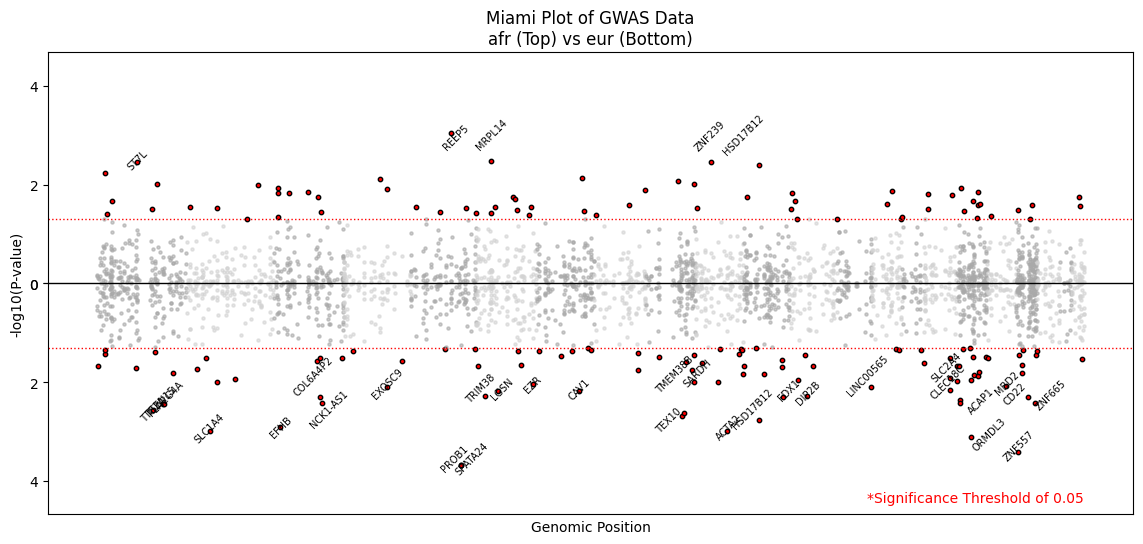

<Figure size 640x480 with 0 Axes>

In [45]:
miami('afr')

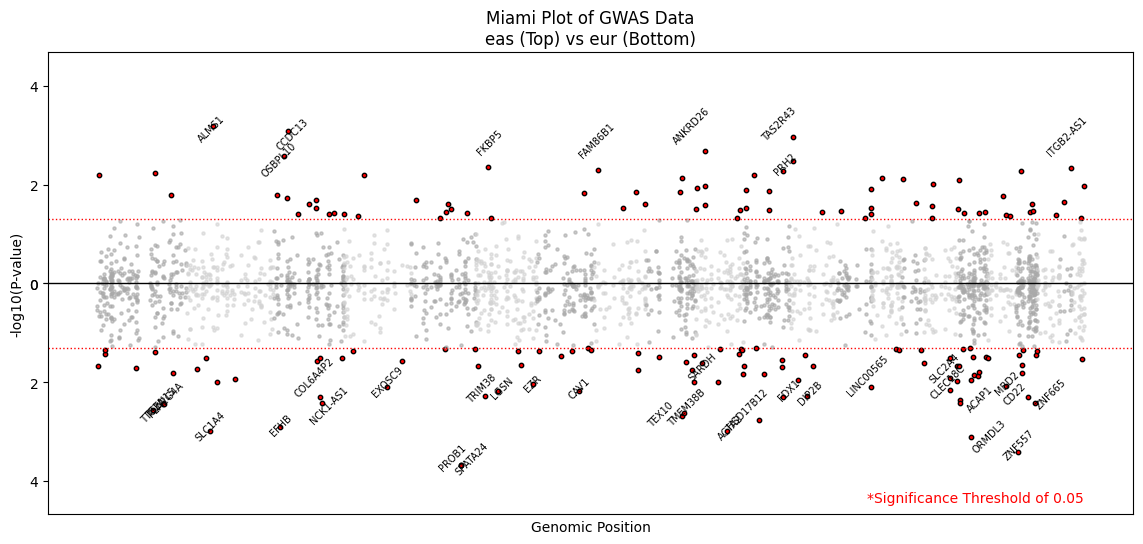

<Figure size 640x480 with 0 Axes>

In [46]:
miami('eas')

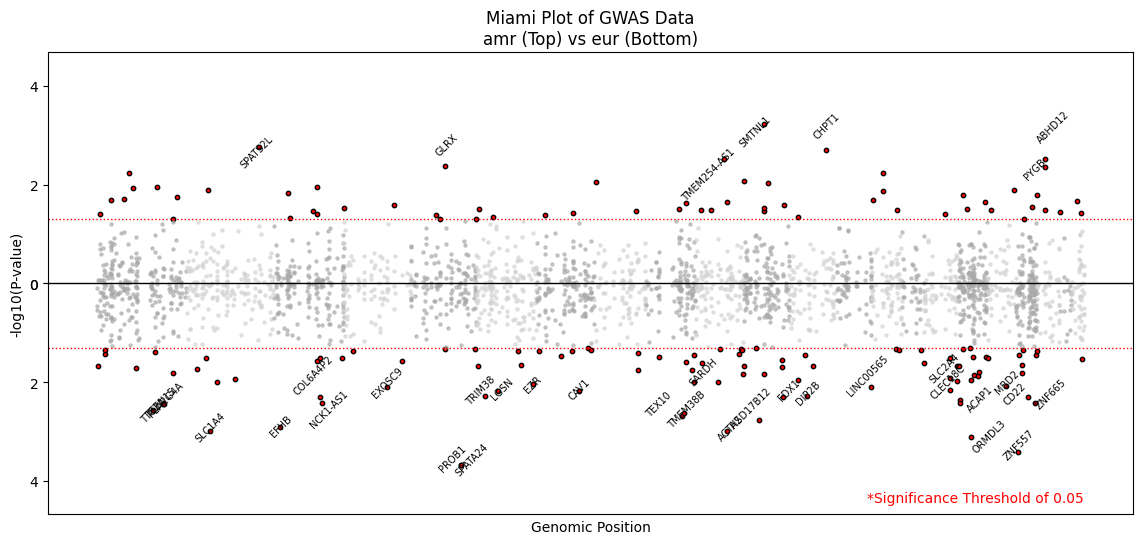

<Figure size 640x480 with 0 Axes>

In [47]:
miami('amr')

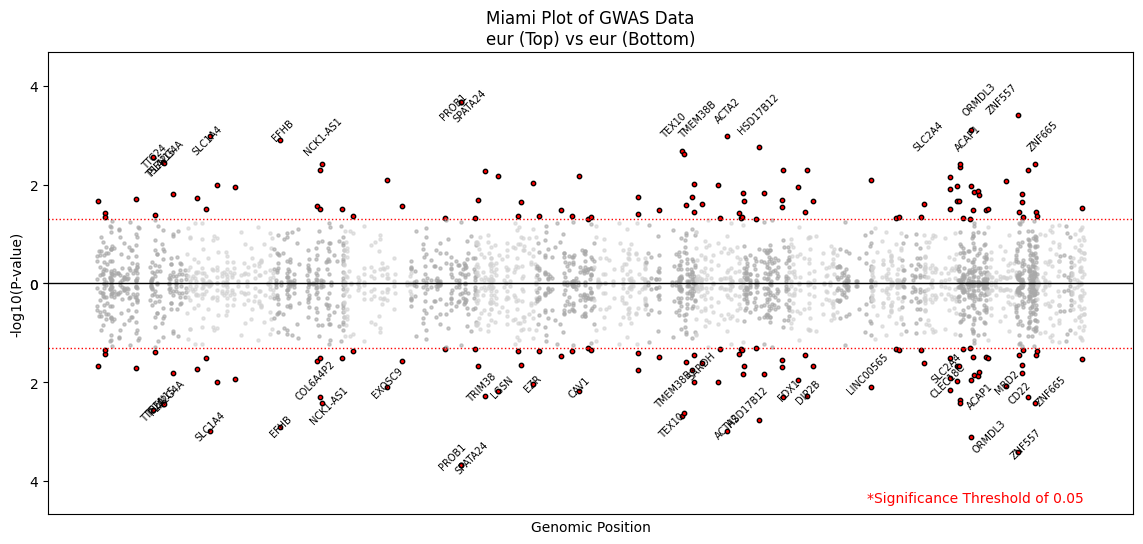

<Figure size 640x480 with 0 Axes>

In [48]:
miami('eur')

In [58]:
def miami_loci(pop):
    """Generates a Miami plot for chromosomes 1-22 comparing given population vs 'eur'."""
    
    # Get GWAS data for both populations across all chromosomes
    df1 = data_prep('eur')
    df2 = data_prep(pop)

    # Set up the plot
    plt.figure(figsize=(14, 6))
    sig_color = 'red'  # Color for significant SNPs
    grey_colors = ['lightgrey', 'darkgrey']  # Alternating grey for non-significant SNPs

    # Track chromosome positions for spacing
    chrom_offsets = {}
    cumulative_pos = 0

    for chrom in range(1, 23):
        chr_data1 = df1[df1['CHR'] == chrom]
        chr_data2 = df2[df2['CHR'] == chrom]

        if not chr_data1.empty and not chr_data2.empty:
            min_pos = min(chr_data1['P0'].min(), chr_data2['P0'].min())
            max_pos = max(chr_data1['P0'].max(), chr_data2['P0'].max())

            chr_data1 = chr_data1.copy()
            chr_data2 = chr_data2.copy()

            chr_data1.loc[:, 'plot_pos'] = chr_data1['P0'] - min_pos + cumulative_pos
            chr_data2.loc[:, 'plot_pos'] = chr_data2['P0'] - min_pos + cumulative_pos

            chrom_offsets[chrom] = cumulative_pos + (max_pos - min_pos) / 2
            cumulative_pos += max_pos - min_pos + 1e6  # Add buffer between chromosomes

            # Identify significant SNPs
            significant1 = chr_data1['-log10(P)'] >= -np.log10(1e-3)
            significant2 = chr_data2['-log10(P)'] >= -np.log10(1e-3)
            significant_annotate1 = chr_data1['-log10(P)'] >= -np.log10(1e-3)
            significant_annotate2 = chr_data2['-log10(P)'] >= -np.log10(1e-3)

            # Plot eur SNPs (bottom)
            plt.scatter(chr_data1['plot_pos'][significant1], -chr_data1['-log10(P)'][significant1],
                        color=sig_color, s=10, edgecolor='black')
            plt.scatter(chr_data1['plot_pos'][~significant1], -chr_data1['-log10(P)'][~significant1],
                        color=grey_colors[chrom % 2], s=5, alpha=0.6)
            
            # Plot pop SNPs (top)
            plt.scatter(chr_data2['plot_pos'][significant2], chr_data2['-log10(P)'][significant2],
                        color=sig_color, s=10, edgecolor='black')
            plt.scatter(chr_data2['plot_pos'][~significant2], chr_data2['-log10(P)'][~significant2],
                        color=grey_colors[chrom % 2], s=5, alpha=0.6)

            # Store all text annotations
            texts = []

            # Annotate significant SNPs with 'ID' (top)
            for i, row in chr_data2[significant_annotate2].iterrows():
                texts.append(plt.text(row['plot_pos'], row['-log10(P)'] + 0.2, row['ID'], 
                                    fontsize=7, ha='center', rotation=45))

            # Annotate significant SNPs with 'ID' (bottom)
            for i, row in chr_data1[significant_annotate1].iterrows():
                texts.append(plt.text(row['plot_pos'], -row['-log10(P)'] - 0.2, row['ID'], 
                                    fontsize=7, ha='center', rotation=45))

            # Adjust text positions to avoid overlap
            adjust_text(texts, 
            expand_text=(1.2, 1.5),  
            expand_points=(1.2, 1.5),  
            force_text=(0.3, 0.5),  
            force_points=(0.3, 0.5),  
            lim=200)  

    # Remove chromosome number blocks
    plt.xticks([])  

    # Adjust y-axis: Keep values negative but display them as positive
    max_y = max(df1['-log10(P)'].max(), df2['-log10(P)'].max()) + 1
    y_ticks = np.arange(0, np.ceil(max_y), 2)
    plt.yticks(list(-y_ticks) + list(y_ticks), labels=[str(int(abs(y))) for y in list(-y_ticks) + list(y_ticks)])
    plt.ylim(-max_y, max_y)  

    # Add genome-wide significance and 1e-3 threshold lines
    plt.axhline(y=0, color='black', linestyle='solid', linewidth=1)
    plt.axhline(y=-np.log10(1e-3), color='red', linestyle='dotted', linewidth=1)
    plt.axhline(y=np.log10(1e-3), color='red', linestyle='dotted', linewidth=1)

    # Add annotation for significance threshold
    plt.text(cumulative_pos * 1, -max_y + 0.25, "*Significance Threshold of 0.001", 
         color='red', fontsize=10, ha='right')

    # Labels and title
    plt.xlabel("Genomic Position")
    plt.ylabel("-log10(P-value)")
    plt.title(f"Miami Plot of GWAS Data\n{pop} (Top) vs eur (Bottom)")

    # Optionally save the plot
    #plt.savefig(f'../plots/miami/{pop}.png', dpi=300)

    # Show the plot
    plt.show()

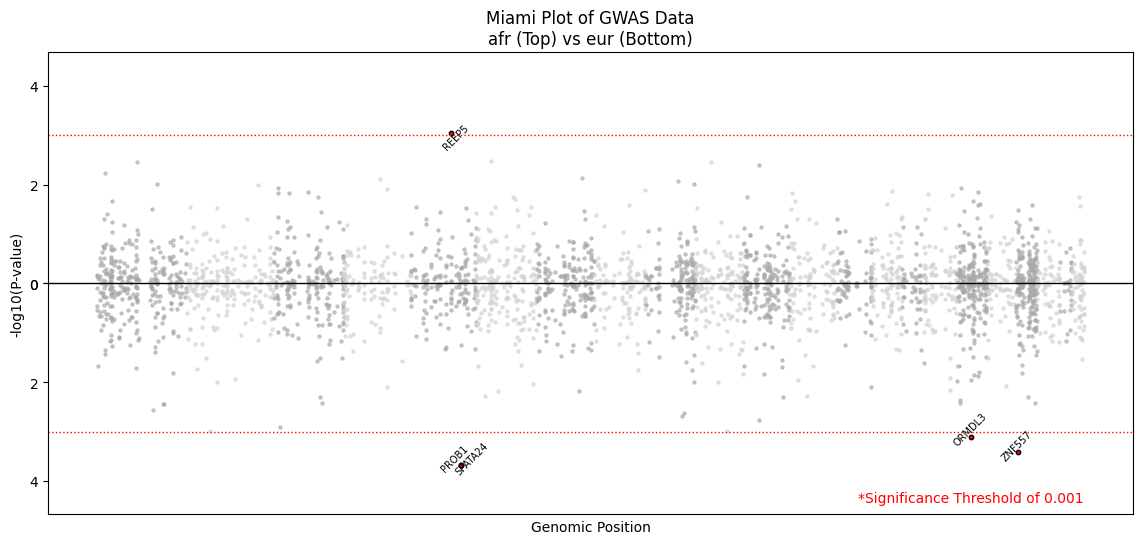

In [59]:
miami_loci('afr')

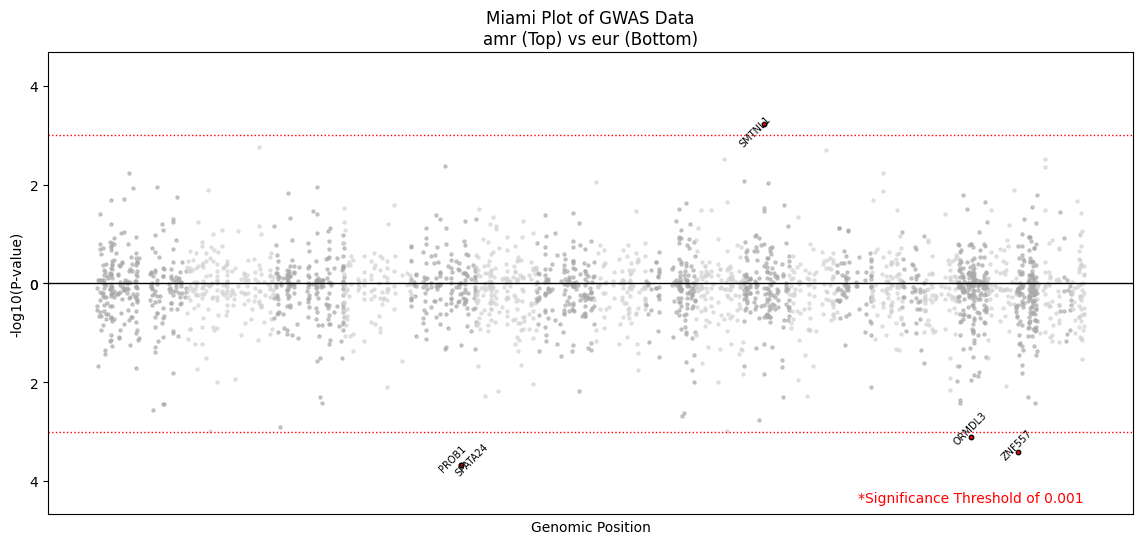

In [60]:
miami_loci('amr')

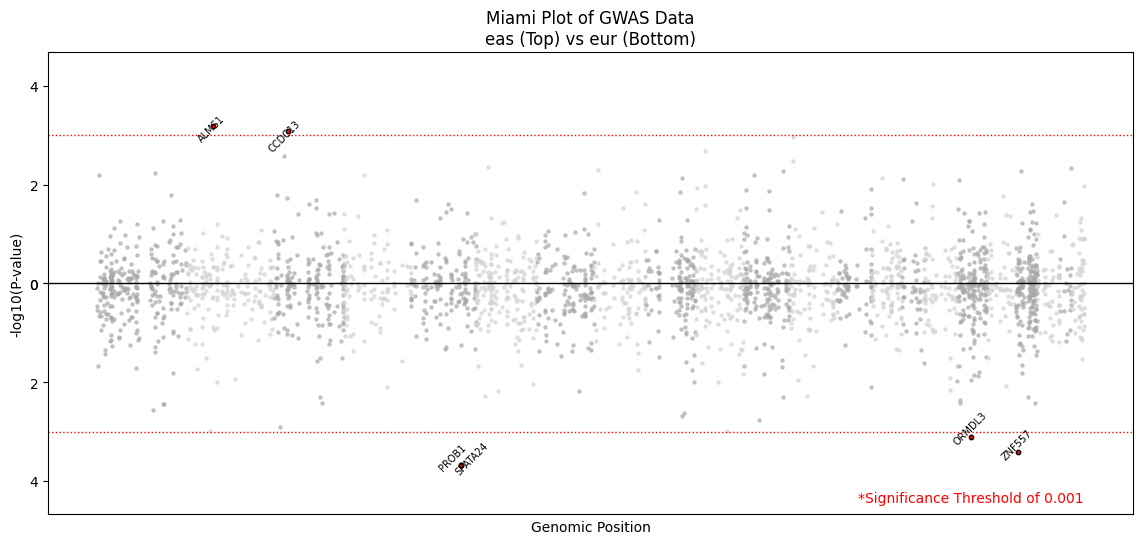

In [61]:
miami_loci('eas')

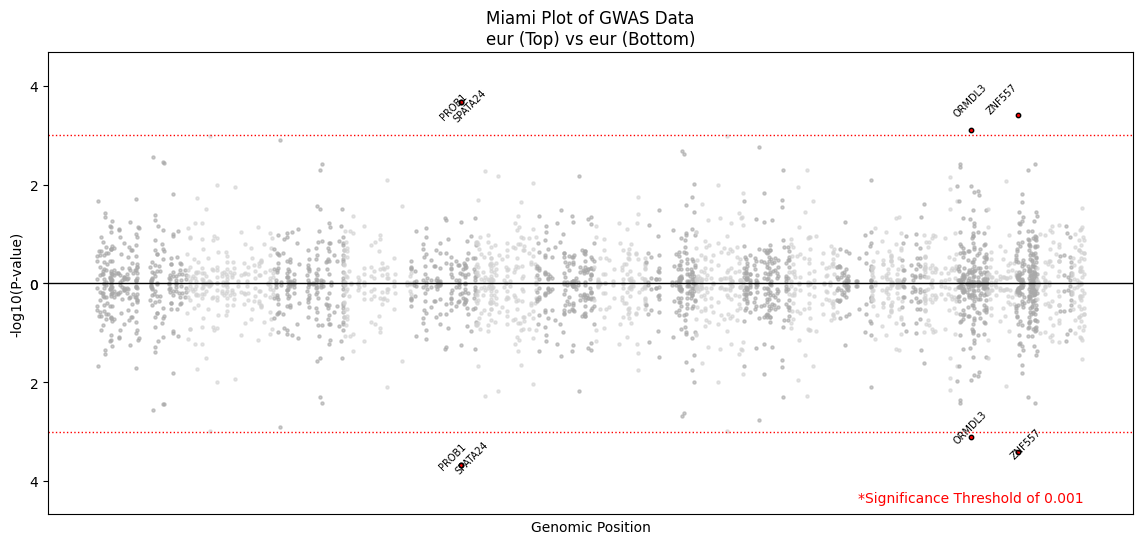

In [62]:
miami_loci('eur')